In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from scipy import stats, optimize
from scipy import linalg as scilin
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from itertools import product
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import sympy as sym

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
sym.init_printing()

## Setup the True Parameters /  Simulation Parameters

In [3]:
true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'phi':-.17,
               'c': .1,
               'delta': 1.22,
               'rho': .6,
              }
time_dim = 3000

## Setup the linking functions.

In [4]:
x, y, rho, c, delta, phi, psi = sym.symbols('x y rho c delta phi psi')

In [5]:
theta, pi = sym.symbols('theta pi')
psi = phi / sym.sqrt(c + (1 + rho)) + (( 1 - phi**2) / 2 - (1 - phi**2) * theta)
a_func = rho * x / ( 1 + c * x)
alpha = psi * x + (( 1 -phi**2) / 2) * x**2
b_func = delta * sym.log(1 + c * x)
beta = a_func.replace(x, pi + alpha.replace(x, theta - 1)) - a_func.replace(x, pi + alpha.replace(x, theta)) 
gamma = b_func.replace(x, pi + alpha.replace(x, theta-1)) - b_func.replace(x, pi + alpha.replace(x, theta))

In [6]:
gamma_lambda = sym.lambdify((rho, c, delta, phi, pi, theta), gamma)
beta_lambda = sym.lambdify((rho, c, phi, pi, theta), beta)
psi_lambda = sym.lambdify((rho,c, phi,  theta), psi)

In [7]:
total_true_params = true_params.copy()
total_true_params.update({'gamma': gamma_lambda(rho=true_params['rho'], c=true_params['c'], 
                                                delta=true_params['delta'],
                                         phi=true_params['phi'], pi=true_params['vol_price'], 
                                          theta=true_params['equity_price']),
                    'beta':beta_lambda(true_params['rho'], true_params['c'], true_params['phi'],
                                       pi=true_params['vol_price'], theta=true_params['equity_price']),
                     'psi':psi_lambda(true_params['rho'], true_params['c'], true_params['phi'],
                                      theta=true_params['equity_price']), 
                      'phi_squared': true_params['phi']**2})

## Setup the Simulation Functions

In [8]:
def simulate_autoregressive_gamma(rho=0, c=1, delta=1, initial_point=None, time_dim=100,
                                  state_date='2000-01-01'):
    """
    This function provides draws from the ARG(1) process of Gourieroux & Jaiak
    
    Parameters
    --------
    rho : scalar
        AR(1) coefficient
    delta : scalar
        intercept
    c : scalar
        scale
    Returns
    -----
    draws : dataframe
    """
    
    # If initial_point is not specified, we start at the unconditional mean.
    
    initial_point = (c * delta) / (1 - rho)
    
    # The conditional distribution of an ARG(1) process is non-centered Gamma, which has a representation as a 
    # Poisson mixture of Gamma
    
    draws = [initial_point]
    
    for _ in tqdm_notebook(range(time_dim)):
        
        latent_var = stats.poisson.rvs(mu = rho * draws[-1] / c)
        draws.append(stats.gamma.rvs(a=delta+latent_var, scale=c))
    
    draws = pd.DataFrame(draws[1:], pd.date_range(start=state_date, freq='D', periods=time_dim))
    return draws
    
    

In [9]:
def simulate_conditional_gaussian(vol_data, rho=0, c=1, delta=1, phi=0, vol_price=0, equity_price=1):
    """
    This function simulates conditional Gaussian random variables with mean
    
    $$E[r_{t+1} | \sigma^2_t, \sigma^2_{t+1}] = \psi \sigma^2_{t+1} + \beta \sigma^2_t + \gamma$$
    $$Var[r_{+t} | \sigma^2_t, \sigma^2_{t+1}] = (1 - \phi^2) \sigma^2_{t+1}$$
    
    Parameters
    ----------
    vol_data : pandas dataframe
        The volatility data. It must always be positive.
    rho : scalar
    c : scalar
    delta : scalar
    phi : scalar 
        It must be in [-1,1]
    vol_price : scalar
    equity_price : scalar
    
    Returns
    -------
    data : pandas dataframe 
        This contains both the vol_data and the return data
    """
    
    gamma = gamma_lambda(rho, c, delta, phi, vol_price, equity_price)
    beta = beta_lambda(rho, c, phi, vol_price, equity_price)
    psi = psi_lambda(rho,c, phi, equity_price)
    
    mean = gamma + beta * vol_data.shift(1) + psi * vol_data
    var = (1 - phi**2) * vol_data
    
    draws =  mean + pd.DataFrame(stats.norm.rvs(0, scale=var.apply(np.sqrt)),
                                 index=vol_data.index)
    data = pd.concat([vol_data, draws], axis=1).dropna()
    data.columns = ['vol', 'rtn']
    
    return data

In [10]:
def simulate_data(equity_price=1, vol_price=0, rho=0, c=1, delta=1, phi=0, initial_point=None, time_dim=100,
                                  state_date='2000-01-01'):
    """
    This function takes the reduced-form paramters and risk prices and returns the data
    
    Parameters
    --------
    equity_price: scalar
    vol_price : scalar
    phi : scalar
        leverage
    rho : scalar
        persistence
    c : positive scalar
        scale
    initial_point: scalar, optional
        Starting value for the volatility
    time_dim : int, optional
        number of periods
    start_date : datelike, optional
        The time to start the data from.
        
    Returns
    -----
    draws : dataframe
    
    """
    vol_data = simulate_autoregressive_gamma(rho=rho, c=c, delta=1, initial_point=initial_point,
                                             state_date=pd.to_datetime(state_date) - pd.Timedelta('1 day'),
                                             time_dim=time_dim + 1)
    data = simulate_conditional_gaussian(vol_data, rho=rho, c=c, delta=delta, phi=phi, vol_price=vol_price,
                                         equity_price=equity_price)

    return data

## We now examine the distributions of simulated data

In [11]:
data = simulate_data(time_dim=time_dim, **true_params)

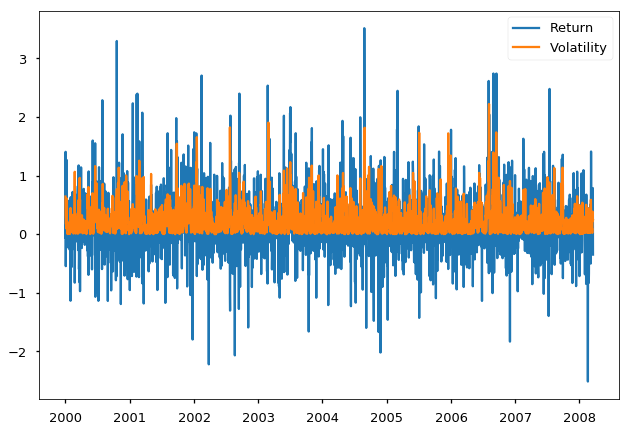

In [12]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()


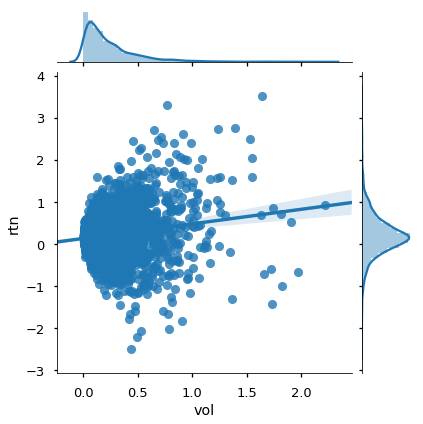

In [13]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [14]:
data.describe()

,vol,rtn
count,3000.000000,3000.000000
mean,0.239997,0.210178
std,0.250459,0.515698
min,0.000015,-2.512462
25%,0.069136,-0.057755
50%,0.159213,0.172726
75%,0.321614,0.449614
max,2.221308,3.514604


## We now define the moment conditions that we can use to estimate volatility

In [15]:
mean = rho * x + c * delta
var = 2 * c * rho * x + c**2 * delta
mom1 = y - mean
mom2 = (y- mean) * x
mom3 = (y**2 - (var + mean**2))
mom4 = (y**2 - (var + mean**2)) * x
mom5 = (y**2 - (var + mean**2)) * x**2

In [16]:
vol_moments_sym = sym.Matrix([mom1,mom2, mom3, mom4, mom5])
vol_moments_lambda = sym.lambdify((x, y, rho, c, delta), vol_moments_sym)

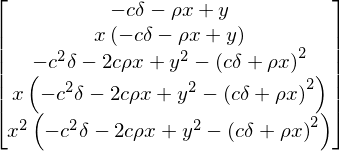

In [17]:
vol_moments_sym

In [18]:
def vol_moments(vol_data, *args):    
    return pd.DataFrame(np.squeeze(vol_moments_lambda(vol_data.values[1:], vol_data.values[:-1], *args)).T)

I use Sympy to compute the gradient

In [19]:
vol_squared_mom = vol_moments_sym.T @ vol_moments_sym
vol_squared_mom_grad = sym.lambdify((x, y, rho, c, delta), vol_squared_mom.jacobian([rho, c, delta]))

In [20]:
def vol_squared_moments_grad(vol_data, *args):
    return  pd.DataFrame(np.squeeze(vol_squared_mom_grad(vol_data.values[1:], vol_data.values[:-1], *args)).T, 
                         index=vol_data.index[1:]).dropna()

In [21]:
vol_moments_grad_lambda = sym.lambdify((x, y, rho, c, delta), vol_moments_sym.jacobian([rho, c, delta]))


In [22]:
def vol_moments_grad(vol_data, *args):
    mom_grad_in  = vol_moments_grad_lambda(vol_data.shift(-1), vol_data, *args)
    return np.array([[np.nanmean(arr_in) for arr_in in arr_out] for arr_out in mom_grad_in])
                         

In [23]:
intercept, persistence = tsa.AR(data.vol).fit(maxlag=1).params
error_var = tsa.AR(data.vol).fit(maxlag=1).sigma2
tsa.AR(data.vol).fit(maxlag=1).conf_int()

,0,1
const,0.086427,0.106324
L1.vol,0.569194,0.626552


From the model, we know that intercept = $ c * \delta$. We also know that the average error variance equals 
$ c^2 \delta * (2 \rho / 1 - \rho) + 1)$ Consequently, $c = error\_var / ( intercept * (2 \rho / 1 - \rho) + 1)) $ and delta = intercept / c


In [24]:
init_constants = {'rho': persistence}

In [25]:
init_constants['c'] = error_var / ( intercept * ( 2 * persistence / ( 1- persistence) + 1) )
init_constants['delta'] = intercept / init_constants['c']

In [26]:
num_vals = 50
cvals = np.linspace(0, 1,num_vals)
deltavals = np.linspace(0,1.5,num_vals)

In [27]:
plot_data = pd.DataFrame(np.asarray([(scale, intercept, vol_moments(data.vol, *[.5, scale, intercept]).apply(
    np.square).sum().mean())
     for scale, intercept in product(cvals, deltavals)]), columns=['c', 'delta', 'z'])
reshaped_x = plot_data.c.values.reshape((num_vals,num_vals))
reshaped_y = plot_data.delta.values.reshape((num_vals,num_vals))
reshaped_z = plot_data.z.values.reshape((num_vals,num_vals))

Text(0.5,0,'c')

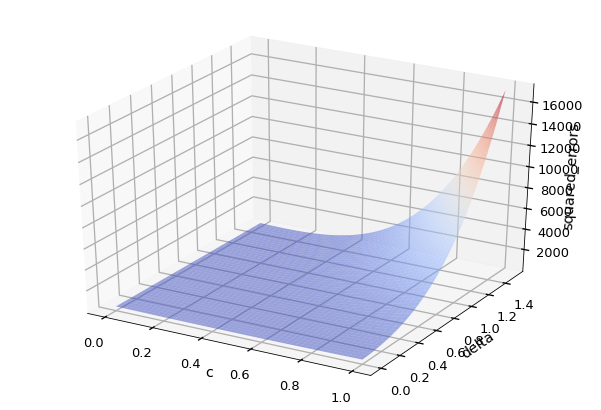

In [28]:
fig = mpl.pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(reshaped_x, reshaped_y, reshaped_z , cmap=cm.coolwarm, alpha=.5)


ax.set_ylabel('delta')
ax.set_zlabel('squared_errors')
ax.set_xlabel('c')


In [29]:
def compute_vol_gmm(vol_data, x0, bounds=None):
    """
    This function uses GMM to compute the volatility paramters and their asymptotic covariance matrix.
    
    Paramters
    ---------
    vol_data : pandas series
    x0 : 3-element vector
    bounds : list
    
    Returns
    --------
    final_result : dict
    cov : ndarray
    """
    if bounds is None:
        bounds = [(-1+1e-5,1-1e-5),(1e-5, 20), (1e-5,20)]
    
    initial_result = optimize.minimize(lambda x: np.mean(np.ravel(vol_moments(vol_data, *x))**2),
                                       x0=list(init_constants.values()), method="SLSQP", bounds=bounds,
                                       options={'maxiter':200}, 
                                       jac= lambda x: np.mean(vol_squared_moments_grad(vol_data, *x), axis=0))
    
    weight_matrix = scilin.inv(vol_moments(vol_data, *initial_result.x).cov())
    root_weight_matrix = scilin.cholesky(weight_matrix)
    
    final_result = optimize.minimize(lambda x:
                                     np.mean(np.ravel((vol_moments(vol_data, *x) @ root_weight_matrix)**2)),
                           x0=initial_result.x, method="SLSQP", bounds=bounds, options={'maxiter':200})

    moment_derivative = vol_moments_grad(vol_data, *final_result.x)
    cov = pd.DataFrame(np.linalg.inv(moment_derivative.T @ weight_matrix @ moment_derivative),
                       columns=list(init_constants.keys()), index=list(init_constants.keys()))
    estimates = {key:val for key,val in zip(init_constants.keys(), final_result.x)}

    return final_result, estimates, cov / (vol_data.size -1)


In [30]:
final_result, params_1st_stage, cov_1st_stage = compute_vol_gmm(data.vol, x0=init_constants)

In [31]:
final_result

     fun: 6.9915920273329215
     jac: array([ -5.50150871e-05,  -4.59253788e-04,  -6.62207603e-05])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([ 0.5982254 ,  0.10671543,  0.9104955 ])

In [32]:
def create_est_table(estimates, truth, cov, num_se=1.96):
    """
    This function creates a table that prints the estimates, truth, and confidence interval
    
    Paramters:
    --------
    names : list of str
        The values to print
    truth : dict
        The true values
    cov : dataframe
        Covariance matrix
    num_se : positive float, optional
        The number of standard errors to use.
    Returns
    -------
    dataframe
    """
    names = set(estimates.keys()).intersection(set(truth.keys()))
    true_values = [truth[name] for name in names]
    est_values = [estimates[name] for name in names]
    
    lower_ci = [estimates[name] - num_se * np.sqrt(cov.loc[name, name]) for name in names]
    upper_ci =[estimates[name] + num_se * np.sqrt(cov.loc[name, name]) for name in names]

    return_df = pd.DataFrame(np.column_stack([true_values, est_values, lower_ci, upper_ci]),
                             columns = ['truth', 'estimate', 'lower ci', 'upper ci'], index=names)
    return_df.sort_index(inplace=True)
    return_df['in_ci'] = ((return_df['truth'] >= return_df['lower ci']) 
                          & (return_df['truth'] <= return_df['upper ci']))
    
    return return_df
    
    

In [33]:
reduced_form_est = create_est_table(estimates=params_1st_stage, truth=true_params, cov=cov_1st_stage)

In [34]:
reduced_form_est

,truth,estimate,lower ci,upper ci,in_ci
c,0.10,0.106715,0.098367,0.115063,True
delta,1.22,0.910496,0.834961,0.986030,False
rho,0.60,0.598225,0.556523,0.639928,True


In [35]:
cov_1st_stage

,rho,c,delta
rho,0.000453,-0.000022,-0.000405
c,-0.000022,0.000018,-0.000073
delta,-0.000405,-0.000073,0.001485


In [36]:
reduced_form_cov = cov_1st_stage.copy()

# Step 2

In [37]:
def compute_step2(data, parameter_mapping=None):
    
    if parameter_mapping is None:
        parameter_mapping = {'vol':'psi', 'vol.shift(1)':'beta', 'Intercept':'gamma'}
    
    wls_results = sm.WLS.from_formula('rtn ~ 1+ vol.shift(1) + vol', weights=data.vol**(-1), data=data).fit()
    
    estimates = wls_results.params.rename(parameter_mapping)
    
    # We force phi^2 >=0
    estimates['phi_squared'] =  np.maximum(1 - np.mean(wls_results.wresid**2), 0)
    
    phi2_cov = pd.DataFrame(np.atleast_2d(np.cov(wls_results.wresid**2)), index=['phi_squared'],
                        columns=['phi_squared'])
    return_cov = wls_results.cov_params().rename(columns=parameter_mapping).rename(parameter_mapping)
    return_cov = return_cov.merge(phi2_cov, left_index=True, right_index=True, how='outer').fillna(0)
    
    return estimates, return_cov
    

In [38]:
step2_est, step2_cov = compute_step2(data)

In [39]:
params_1st_stage.update(step2_est)
cov_1st_stage = reduced_form_cov.merge(step2_cov, left_index=True, right_index=True, how='outer').fillna(0)

In [40]:
create_est_table(estimates=params_1st_stage, truth=total_true_params, cov=cov_1st_stage)


,truth,estimate,lower ci,upper ci,in_ci
beta,0.803285,0.786629,0.728697,0.844560,True
c,0.100000,0.106715,0.098367,0.115063,True
delta,1.220000,0.910496,0.834961,0.986030,False
gamma,0.050968,0.061184,0.051795,0.070573,False
phi_squared,0.028900,0.043146,-2.714412,2.800703,True
psi,-0.130384,-0.165531,-0.245002,-0.086061,True
rho,0.600000,0.598225,0.556523,0.639928,True


## I now setup the second-stage derivation

In [41]:
second_stage_moments_sym = sym.Matrix([beta, c, delta, gamma, phi**2, psi, rho])
second_stage_moments_sym.simplify()
second_stage_moments = sym.lambdify((c, delta, phi, pi, rho, theta), second_stage_moments_sym)

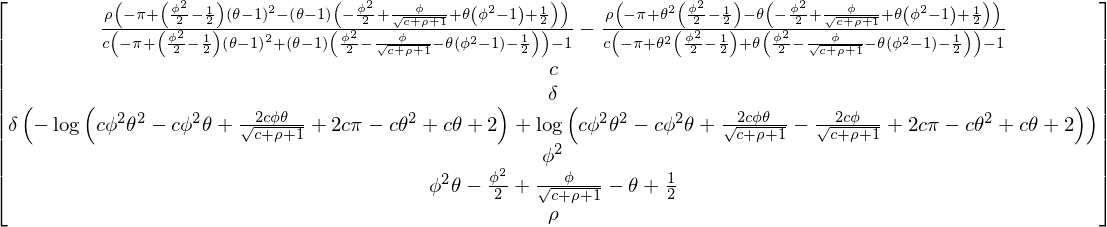

In [42]:
second_stage_moments_sym

In [43]:
link1_grad_in = sym.lambdify((c, delta, phi, pi,rho, theta),  
                             second_stage_moments_sym.jacobian([c,delta, rho]))

In [44]:
def link_grad_reduced(c, delta, equity_price, phi, rho, vol_price):
    """
    This function computes the jacobian of the link function with respect to the reduced form paramters
    beta, c, delta, gamma, phi^2, psi, rho
    
    Paramters
    ---------
    c : scalar
    equity_price : scalar
    phi : scalar
    rho : scalar
    vol_price : scalar
    
    Returns
    --------
    ndarray
    
    """
    return_mat = np.zeros((7,7))
    mat2 = link1_grad_in(phi=phi, rho=rho, c=c, delta=delta, theta=equity_price, pi=vol_price)
    return_mat[0,0] = 1
    return_mat[:,1] = mat2[:,0]
    return_mat[:,2] = mat2[:,1]
    return_mat[3,3] = 1
    return_mat[4,4] = 1
    return_mat[5,5] = 1
    return_mat[:,6] = mat2[:,2]
    
    return return_mat
    

In [45]:
link2_grad_in = sym.lambdify((rho, c, delta, phi, pi, theta), 
                                  second_stage_moments_sym.jacobian([rho, c, delta, phi, pi, theta]))

In [46]:
def link_grad_structural(rho, c, delta, phi, equity_price, vol_price):
    """
    This function computes the jacobian of the link function with respect to the structural paramters
    phi, rho, c, delta, equity_price, and vol_price
    
    Paramters
    ---------
    rho : scalar
    c : scalar
    phi : scalar
    equity_price : scalar
    vol_price : scalar
    
    Returns
    --------
    ndarray
    
    """
    return_mat = link2_grad_in(phi=phi, rho=rho, c=c, delta=delta, theta=equity_price, pi=vol_price)
    
    return return_mat
    

In [47]:
def second_criterion(structural_params, link_params, weight=None):
    """
    This function computes the weighted squared deviations as defined by the link function.
    The paramters to estimate must be in alphabetical order.
    
    Paramters
    ----------
    structural_params : ndarray
    link_params : ndarray
    
    Returns
    ------
    scalar
    
    """
    c_link, beta, delta_link, gamma, psi, phi_squared, rho_link = link_params
    c, delta, equity_price, phi, rho, vol_price = structural_params
    
    part1 = second_stage_moments(rho=rho, c=c, delta=delta, theta=equity_price, phi=phi, pi=vol_price).ravel()
    part2 = np.array([link_params[key] for key in sorted(link_params)])

    diff = part1 - part2
    
    if weight is None:
        weight = np.eye(len(diff))
            
    return .5 * diff @ weight @ diff
    

We sometimes get invalid values inside the logarithm for non-optimal values. This would induce a complicated nonlinear constraint for the valid values of the volatilty risk price, but they do not bind, and so we don't bother imposing them.

In [48]:
def compute_stage2_weight(reduced_form_cov, structural_params):
    return  np.linalg.inv(link_grad_structural(**structural_params).T @ link_grad1(**structural_params).T)

In [49]:
def est_2nd_stage(reduced_form_params, reduced_form_cov, bounds=None, opts=None):
    
    if bounds is None:
        bounds = ([0,.5], [0, np.inf], [0, 10], [-1,1], [0,1], [-50, 50])
    if opts is None:
        opts = {'maxiter':200}
        
    price_guess = {'equity_price': .5, 'vol_price': -1, 'phi': - np.sqrt(reduced_form_params['phi_squared']),
                   'rho': reduced_form_params['rho'], 'c':reduced_form_params['c'], 
                   'delta':reduced_form_params['delta']}
    x0 = [price_guess[val] for val in sorted(price_guess.keys())]
   
    init_result = optimize.minimize(lambda x: second_criterion(x, reduced_form_params), x0=x0, method="SLSQP",  
                                    options=opts, bounds=bounds)
    estimates = {key:val for key, val in zip(sorted(price_guess.keys()), init_result.x)}
    
    weight = np.linalg.pinv(link_grad_reduced(**estimates).T @ reduced_form_cov.sort_index().T.sort_index() 
               @ link_grad_reduced(**estimates))
    
    final_result = optimize.minimize(lambda x: second_criterion(x, reduced_form_params, weight=weight),
                                     x0=init_result.x, method="SLSQP",  options=opts, bounds=bounds)
                                     
    estimates = {key:val for key, val in zip(sorted(price_guess.keys()), final_result.x)}
                  
    return final_result, estimates

In [50]:
 stage2_result, params_2nd_stage = est_2nd_stage(reduced_form_params=params_1st_stage, 
                                               reduced_form_cov=cov_1st_stage)

<string>:2: RuntimeWarning: invalid value encountered in log


In [51]:
stage2_result

     fun: 6.6893124317195625
     jac: array([  7.24164826e+04,  -4.73414439e+00,   2.36153045e+02,
        -1.03994368e+04,   3.21886402e+03,  -1.45573708e+03])
 message: 'Optimization terminated successfully.'
    nfev: 85
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.11373099,  0.98911831,  0.49016065, -0.21383158,  0.5838503 ,
       -5.84535803])

## I now compute the covariance matrix for this 2nd stage regression

I first compute the bread for the sandwich

In [52]:
def compute_2nd_stage_cov(params2, cov1):
    
    # This is the optimal weight matrix. 
    weight = np.linalg.pinv(link_grad_reduced(**params2).T @ cov_1st_stage.sort_index().T.sort_index() 
               @ link_grad_reduced(**params2))
    
    # This is the inverse of the bread for the sandwich
    Bmat = (link_grad_structural(**params2).T @ weight @ link_grad_structural(**params2))
    
    cov = pd.DataFrame((np.linalg.inv(Bmat) @ link_grad_structural(**params2).T @ weight 
       @ link_grad_structural(**params2) @ np.linalg.inv(Bmat)) / data.shape[0], 
                            index=params2.keys(), columns=params2.keys())
    return cov

In [53]:
cov_2nd_stage = compute_2nd_stage_cov(params2=params_2nd_stage, cov1=cov_1st_stage)

In [54]:
create_est_table(estimates=params_2nd_stage, truth=total_true_params, cov=cov_2nd_stage)

,truth,estimate,lower ci,upper ci,in_ci
c,0.10,0.113731,0.112561,0.114901,False
delta,1.22,0.989118,0.968645,1.009592,False
equity_price,0.50,0.490161,0.488782,0.491540,False
phi,-0.17,-0.213832,-0.290222,-0.137441,True
rho,0.60,0.583850,0.103844,1.063857,True
vol_price,-7.00,-5.845358,-5.908609,-5.782107,False
